## Time Series Forecasting with Prophet

`Prophet` is an open-source time series forecasting library created by Facebook (now Meta) that handles seasonality, trends, and holidays in data. 

It uses an `additive model` to decompose time series into trend, yearly, weekly, and daily seasonality components, plus holiday effects.

Prophet is particularly effective for business time series and data with strong seasonal patterns and works well with missing data and outliers.  

### How it Works
1. **Additive Model**: Prophet models the time series as a sum of several components:
- `Trend`: A non-linear trend that can change over time, detected using changepoints. 
- `Seasonality`: Yearly, weekly, and daily seasonal patterns are modeled using Fourier series. 
- `Holidays`: The impact of holidays is modeled using a vector of dummy variables. 
- `Error Term`: The remaining part of the time series is considered the error term. 

2. **Data Requirements**: The input data must be in a pandas DataFrame with two specific columns: `ds` for the time series and `y` for the values to be forecasted, with `ds` in DateTime format. 

3. **Key Features**:
- `Robustness`: It is robust to missing data and outliers.
   - Outliers (extreme spikes or drops) can distort many forecasting models.
   - Prophet uses a `piecewise linear` or `logistic growth` model and a robust `loss function` so that unusual points have less influence on the forecast.
   - This prevents a single abnormal event from pulling the entire trend line up or down.
- `Seasonality Handling`: It can handle strong seasonal patterns and allows for the definition of custom seasonalities. 
- `Holiday Effects`: The model automatically accounts for holiday impacts and can incorporate user-defined holiday effects. 
- `Changepoint Detection`: It automatically detects abrupt changes in the trend. 
- `Diagnostics`: Prophet includes built-in tools for time series cross-validation to measure forecast accuracy. 

### When to Use It

Prophet is best suited for time series that have: 
- Strong seasonal patterns (yearly, weekly, or daily).
- Several seasons of historical data.
- Data with missing values or outliers.
- Business time series, such as sales or traffic data.

### Implementation

#### Load the libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

#### Load the Data

Pick one index to forecast, e.g., S&P 500 (spx)

In [37]:
df = pd.read_csv("Index2018.csv")
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


### Data Preprocessing

In [ ]:
#convert date column to datetime
#error='coerce' will turn invalid parsing into NaT
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

In [ ]:
# rename columns, drop NaNs, and sort by date
df = df[['date','spx']].rename(columns={'date':'ds','spx':'y'}).dropna().sort_values('ds')

In [ ]:
# ensure 'y' is numeric, coerce errors to NaN
df['y'] = pd.to_numeric(df['y'], errors='coerce')

In [ ]:
# drop rows where 'y' is NaN and reset index
df = df.dropna(subset=['y']).reset_index(drop=True)

In [42]:
df.head()

,ds,y
0,1994-01-07,469.90
1,1994-01-10,475.27
2,1994-01-11,474.13
3,1994-01-12,474.17
4,1994-01-13,472.47


#### Train/Test Split

In [43]:
# 80:20 split
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()
print(f"Train rows: {len(train)}, Test rows: {len(test)}")

Train rows: 5015, Test rows: 1254


#### Fit the Prophet Model

In [44]:
#Fit Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train)

22:28:23 - cmdstanpy - INFO - Chain [1] start processing
22:28:26 - cmdstanpy - INFO - Chain [1] done processing


### Make Predictions

In [45]:
# Create future dataframe for the entire period (train + test)
future = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(),
                                           end=df['ds'].max(),
                                           freq='B')})  # B = business days

forecast = model.predict(future)

In [46]:
# Merge predictions with test set
merged = pd.merge(
    test[['ds','y']].rename(columns={'y':'y_true'}),
    forecast[['ds','yhat','yhat_lower','yhat_upper']],
    on='ds',
    how='left'
).set_index('ds')

In [47]:
# Evaluate
mae  = mean_absolute_error(merged['y_true'], merged['yhat'])
rmse = math.sqrt(mean_squared_error(merged['y_true'], merged['yhat']))
mape = np.mean(np.abs((merged['y_true'] - merged['yhat']) / merged['y_true'])) * 100

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE : 220.38
RMSE: 245.75
MAPE: 10.31%


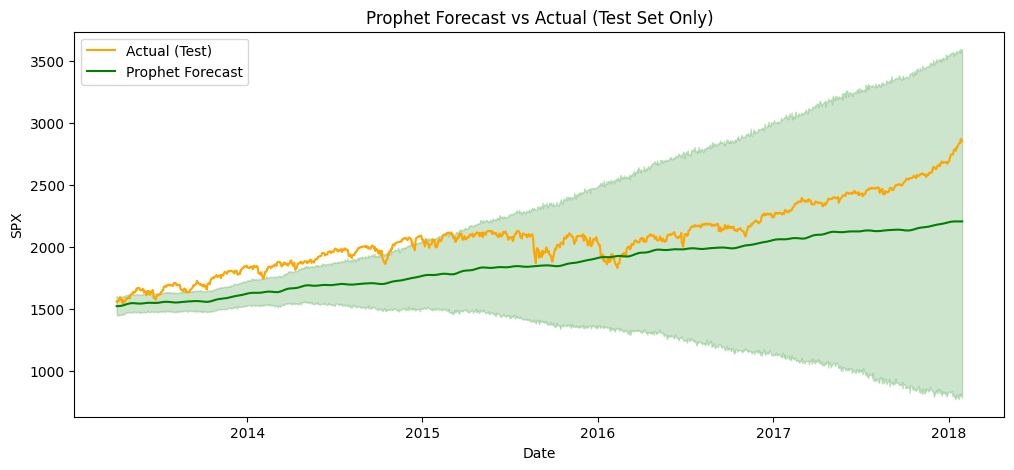

In [48]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(merged.index, merged['y_true'], label='Actual (Test)', color='orange')
plt.plot(merged.index, merged['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(merged.index, merged['yhat_lower'], merged['yhat_upper'],
                 color='green', alpha=0.2)
plt.title('Prophet Forecast vs Actual (Test Set Only)')
plt.xlabel('Date')
plt.ylabel('SPX')
plt.legend()
plt.show()

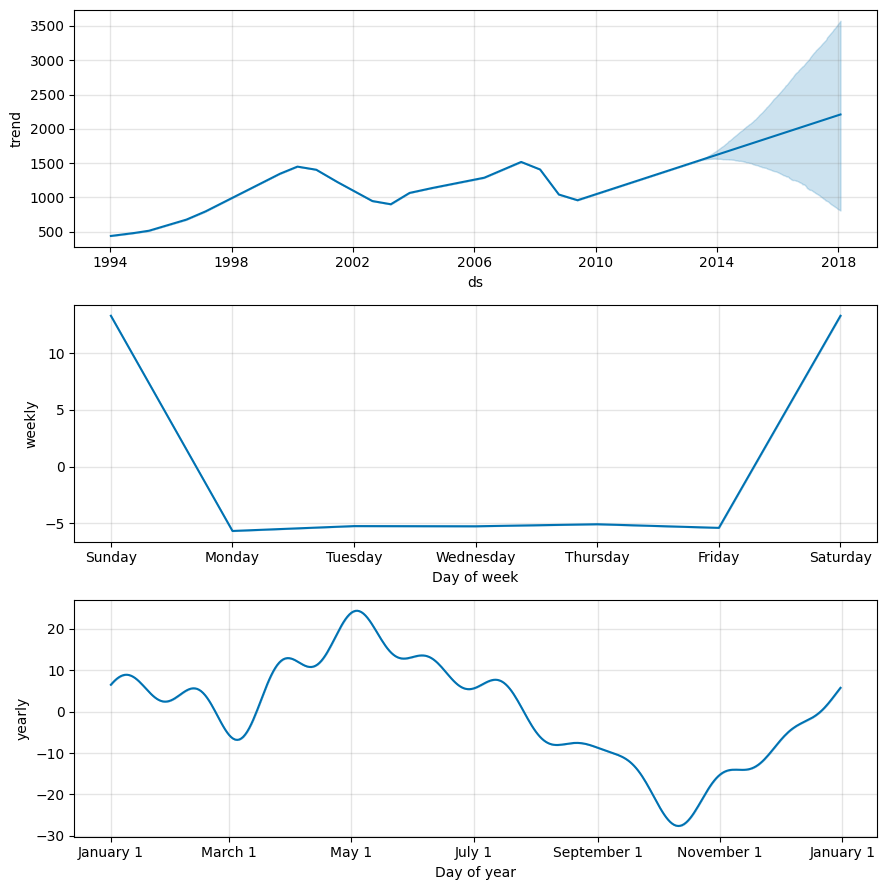

In [49]:
# Prophet component plots
model.plot_components(forecast)
plt.show()